In [1]:
import pydatasci as pds
from pydatasci import aidb
import os, sqlite3, io, gzip 
import pandas as pd
import numpy as np

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from importlib import reload; aidb.delete_db(True); reload(aidb); aidb.create_db()


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created database file for machine learning metrics at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created the following tables within database:
['algorithm', 'dataset', 'featureset', 'job', 'label', 'splitset']



---

In [3]:
d = aidb.Dataset.from_file('iris.csv','csv')
l = aidb.Label.from_dataset(d.id,'target')

---

In [4]:
def check_f(f):
    print(f.columns)
    print(f.supervision)
    print(f.contains_all_columns)

In [5]:
f1 = aidb.Featureset.from_dataset(dataset_id=d.id, label_id=l.id)

In [6]:
check_f(f1)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
supervised
True


In [7]:
f2 = aidb.Featureset.from_dataset(
    dataset_id=d.id
    ,label_id=l.id 
    ,columns=['petal width (cm)', 'petal length (cm)'])

In [8]:
check_f(f2)

['petal width (cm)', 'petal length (cm)']
supervised
False


In [9]:
f3 = aidb.Featureset.from_dataset(
    dataset_id=d.id
    ,label_id=l.id 
    ,columns=['petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)'])

In [10]:
check_f(f3)

['petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)']
supervised
True


In [11]:
f4 = aidb.Featureset.from_dataset(dataset_id=d.id)

In [12]:
check_f(f4)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']
unsupervised
True


In [13]:
f5 = aidb.Featureset.from_dataset(
    dataset_id=d.id
    ,columns=['petal width (cm)', 'petal length (cm)']
)

In [14]:
check_f(f5)

['petal width (cm)', 'petal length (cm)']
unsupervised
False


In [15]:
f6 = aidb.Featureset.from_dataset(
    dataset_id=d.id
    ,columns=['petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)', 'target'])

In [16]:
check_f(f6)

['petal width (cm)', 'petal length (cm)', 'sepal width (cm)', 'sepal length (cm)', 'target']
unsupervised
True


---

In [17]:
def check_s(s):
    print(s.sizes)
    print(s.is_validated)
    print(s.is_folded)

In [18]:
s1 = aidb.Splitset.from_featureset(featureset_id=f1.id, size_test=0.20, size_validation=0.12)

In [19]:
check_s(s1)

{'validation': {'percent': 0.12, 'count': 18}, 'test': {'percent': 0.2, 'count': 30}, 'train': {'percent': 0.68, 'count': 102}}
True
False


In [20]:
s2 = aidb.Splitset.from_featureset(featureset_id=f1.id, size_test=0.20)

In [21]:
check_s(s2)

{'test': {'percent': 0.2, 'count': 30}, 'train': {'percent': 0.8, 'count': 120}}
False
False


In [22]:
s3 = aidb.Splitset.from_featureset(featureset_id=f4.id)

In [23]:
check_s(s3)

{'train': {'percent': 1.0, 'count': 150}}
False
False


In [25]:
s4 = aidb.Splitset.from_featureset(featureset_id=f1.id)

In [26]:
check_s(s4)

{'test': {'percent': 0.25, 'count': 38}, 'train': {'percent': 0.75, 'count': 112}}
False
False


---

- For kfold I would not recommend multiple iterations.
- For regular fold I would recommend it.

> You either have a 2 (train-test) or 3 (train-val-test) way split. Then it's a question of whether or not you are generating kfolds in your training set.

^ Can sklearn kfold preserve index?

^ Stratified on continuous target?

---

Does train_test_split give different indices each time? = YES

In [35]:
f.columns

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [36]:
l.column

'target'

In [39]:
f_data = aidb.Dataset.read_to_numpy(id=1, columns=f.columns)
f_data[:4]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2]])

In [40]:
l_data = aidb.Dataset.read_to_numpy(id=1, columns=l.column)
l_data[:4]

array([[0.],
       [0.],
       [0.],
       [0.]])

In [45]:
row_count = l_data.shape[0]
arr_idx = np.arange(row_count)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
features_train1, features_test1, labels_train1, labels_test1, indices_train1, indices_test1 = train_test_split(
    f_data, l_data, arr_idx
    ,stratify = l_data
)

In [48]:
features_train2, features_test2, labels_train2, labels_test2, indices_train2, indices_test2 = train_test_split(
    f_data, l_data, arr_idx
    ,stratify = l_data
)

In [49]:
indices_train2 == indices_train1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [50]:
indices_test2 == indices_test1

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [51]:
indices_train1_lst, indices_test1_lst, indices_train2_lst, indices_test2_lst = indices_train1.tolist(), indices_test1.tolist(), indices_train2.tolist(), indices_test2.tolist()

In [63]:
length_train = len(indices_train2_lst)
length_test = len(indices_test2_lst)

In [66]:
for i in range(length_train):
    print(indices_train1_lst[i] in indices_train2_lst)

True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
False
True
True
False
True
True
False
True
False
True
True
False
True
True
True
True
True
True
False
False
False
False
False
False
True
True
True
True
False
True
False
True
False
False
False
False
False
True
True
True
True
True
True
True
True
False
True
True
True
False
True
True
False
False
True
False
True
True
True
False
False
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
False
True
True


In [67]:
for i in range(length_test):
    print(indices_test1_lst[i] in indices_test2_lst)

False
False
False
True
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
True
True
False
False
False


---

Overview: https://scikit-learn.org/stable/modules/cross_validation.html

Split Methods: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

There is no stratified split for continuous variables:
- 2 way split binning workaround: https://stackoverflow.com/a/39501510/5739514
- kfold sklearn-based approach: https://github.com/scikit-learn/scikit-learn/issues/4757#issuecomment-694924478

In [267]:
flts = np.arange(117, 1080, 3.13)
rand_flts = np.random.choice(flts, size=150)  

In [268]:
rand_flts

array([ 777.43,  743.  ,  924.54,  617.8 ,  195.25,  993.4 ,  890.11,
        639.71,  774.3 ,  846.29,  135.78,  774.3 ,  780.56,  802.47,
        282.89,  204.64,  276.63,  123.26,  630.32,  955.84,  426.87,
        548.94,  949.58,  990.27,  373.66,  974.62, 1056.  ,  589.63,
       1002.79,  905.76,  370.53,  733.61,  326.71,  379.92,  439.39,
        746.13,  564.59, 1062.26,  824.38,  915.15,  232.81,  558.33,
        517.64,  592.76,  530.16,  480.08,  170.21,  630.32,  223.42,
        326.71,  376.79,  680.4 ,  893.24,  595.89,  489.47, 1015.31,
        658.49,  351.75, 1071.65, 1012.18,  968.36,  398.7 ,  307.93,
        874.46,  749.26,  226.55,  157.69,  764.91,  774.3 , 1043.48,
        586.5 ,  129.52,  386.18,  649.1 ,  207.77,  724.22,  232.81,
        148.3 ,  686.66,  661.62,  855.68,  267.24,  489.47,  464.43,
        968.36,  905.76,  777.43,  464.43,  868.2 ,  780.56,  480.08,
        364.27,  404.96,  774.3 ,  486.34,  411.22, 1071.65,  379.92,
        771.17,  955

(array([16., 20., 14., 14., 16., 15., 20., 18., 17.]),
 array([ 123.26      ,  228.63666667,  334.01333333,  439.39      ,
         544.76666667,  650.14333333,  755.52      ,  860.89666667,
         966.27333333, 1071.65      ]),
 <BarContainer object of 9 artists>)

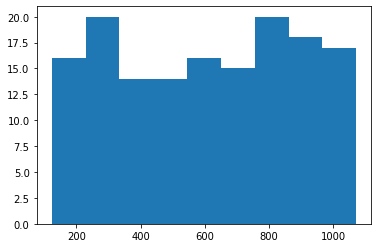

In [269]:
import matplotlib.pyplot as plt
plt.hist(rand_flts, bins='auto')

In [282]:
max = np.amax(rand_flts)
min = np.amin(rand_flts)
print(min)
print(max)

123.25999999999999
1071.6499999999987


In [331]:
num_bins = 4

In [332]:
bins = np.linspace(start=min, stop=max, num=num_bins)
bins

array([ 123.26,  439.39,  755.52, 1071.65])

In [333]:
# Without `right=True`, it will make the max value a separate bin.
flts_binned = np.digitize(rand_flts, bins, right=True)
flts_binned

array([3, 2, 3, 2, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 2, 3, 1, 2,
       3, 3, 1, 3, 3, 2, 3, 3, 1, 2, 1, 1, 1, 2, 2, 3, 3, 3, 1, 2, 2, 2,
       2, 2, 1, 2, 1, 1, 1, 2, 3, 2, 2, 3, 2, 1, 3, 3, 3, 1, 1, 3, 2, 1,
       1, 3, 3, 3, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 3, 1, 2, 2, 3, 3, 3, 2,
       3, 3, 2, 1, 1, 3, 2, 1, 3, 1, 3, 3, 1, 3, 2, 2, 2, 3, 1, 1, 2, 2,
       2, 1, 1, 3, 1, 3, 2, 2, 1, 1, 3, 2, 2, 1, 2, 2, 1, 1, 1, 3, 3, 1,
       1, 3, 3, 3, 1, 3, 1, 3, 2, 3, 1, 3, 2, 1, 2, 3, 3, 1])

^ these are just wrong. there are plenty in bin 3.

Let's pretend `flts` is the target

In [334]:
features_train, features_test, labels_train, labels_test = train_test_split(
    f_data, rand_flts,
    stratify = y_binned
)

(array([28., 26., 26., 32.]),
 array([ 123.26  ,  360.3575,  597.455 ,  834.5525, 1071.65  ]),
 <BarContainer object of 4 artists>)

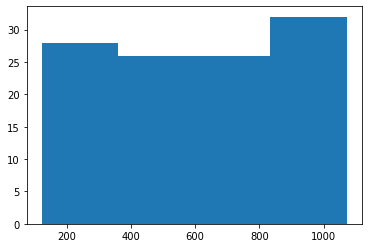

In [335]:
plt.hist(labels_train, bins=num_bins) 

(array([10.,  8., 13.,  7.]),
 array([ 129.52  ,  365.0525,  600.585 ,  836.1175, 1071.65  ]),
 <BarContainer object of 4 artists>)

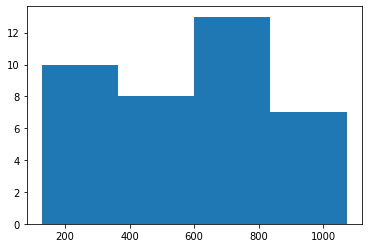

In [336]:
plt.hist(labels_test, bins=num_bins) 

---

In [2]:
s = aidb.Splitset.get_by_id(1)

In [3]:
dct = s.read_to_pandas()

In [4]:
dct

{'validation': {'features':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
  0                  5.1               3.5                1.4               0.2
  1                  4.9               3.0                1.4               0.2
  2                  4.7               3.2                1.3               0.2
  3                  4.6               3.1                1.5               0.2
  4                  5.0               3.6                1.4               0.2
  ..                 ...               ...                ...               ...
  145                6.7               3.0                5.2               2.3
  146                6.3               2.5                5.0               1.9
  147                6.5               3.0                5.2               2.0
  148                6.2               3.4                5.4               2.3
  149                5.9               3.0                5.1               1.8
  
  [150 rows